# Radar Aeroecology Virtual Lab tutorial

![images/Ravl_flowchart.png](images/Ravl_flowchart.png)

This tutorial introduces the Radar Aeroecology Virtual Lab (RAVL), a tool developed by the [Animal Movement Ecology](https://ibed.uva.nl/content/research-departments/theoretical-and-computational-ecology/research/animal-movement-ecology/animal-movement-ecology.html) research group at the University of Amsterdam. RAVL simplifies the process of extracting animal movement data from weather radars. You will get to know its capabilities by exploring how the lab identifies mass migration events of small passerine birds. For a quick overview of the underlying concepts, watch [this 2 minute animation from the GloBAM project](https://www.youtube.com/watch?v=BjQQeXGvYc4). 

#### Prerequisites
For the first exercise no programming experience is required. From exercise 2 and onwards you will be asked to execute blocks of code within this notebook, so some experience working in Jupyter Notebooks is useful. 

## Background information
### Passerines 
Small passerine birds migrate en masse during Spring and Fall. Passerine birds do not migrate continuously throughout the migration season but instead seemingly wait for favorable weather conditions. These weather conditions have been identified to a certain extend and as such certain moments can be defined on which peak migration would likely occur. These migration events can be significant enough to observe on Meteorological Radars. 
### Meteorological Radar & Biological scatters
Meteorological radars monitor the sky 24/7 by emitting a beam and detecting their reflections. These reflections are measured on a number of [elevation angles](https://en.wikipedia.org/wiki/Weather_radar#/media/File:Radar-hauteur-en.svg). While these radars are primarily designed for weather observation, most airborne objects, including birds, reflect a portion of the radar's beam. The phenomenom of radar beams being scattered by animals (e.g., birds, bats, and insects) is called biological scatter. This makes meteorological radars a valuable tool for observing large-scale bird migration events. However, as meteorological radar is not purposefully built to detect small passerines, some effort has to be made to produce meaningful data. Furthermore, a device measuring 24/7 produces much more data than research institues can handle, so some pruning is required. 

###  Polar volume
Polar volume data is the collection of data as measured by meteorological weather radars. The polar volume data represents 3D data; these dimensions are described in [polar coordinates](https://en.wikipedia.org/wiki/Polar_coordinate_system). Therefore, polar volume data has attributes such as `range gates`, `elevation angle` and `azimuth angle` which can be used to map and project the data in various [coordinate systems](https://en.wikipedia.org/wiki/Coordinate_system). The radar measures quite a number of parameters where `reflectivity` (DBZH) and `radial velocity` (VRADH) are the most common. In this tutorial we will be using the Herwijnen radar operated by the KNMI. KNMI has a website that also lists meta-data about the various radars. [Here](https://browser.dataplatform.knmi.nl/metadata/radar_volume_full_herwijnen~1.0~metadata.xml) you can have a look at the description of the variables measured by the Herwijnen radar. 

## Exercises
### Introduction
In this tutorial you will be introduced to some of the core principles of radar aeroecology, specifically meteorological radar data analysis. You will download meteorological radar data from the Netherands Meteorological Institute (KNMI), process that data, visualize and interpret the animal migration information obtained from that data. You will be introduced to more advanced visualization techniques in R by using the `bioRad` ([paper](https://onlinelibrary.wiley.com/doi/10.1111/ecog.04028), [library documentation](https://adriaandokter.com/bioRad/articles/bioRad.html)) package. As we have a decent understanding of favorable weather conditions we can narrow down our search towards the few times in the year that we have favorable conditions for passerines. Furthermore, we can apply certain transformations to the data which will allow us to filter, summarize and visualize the data which will help us focus on the actual migration rather than weather phenomena. 

#### Exercise notes
Most exercises have a `Note:` section. This section generally explains a bit more about the how and what. This information is not necessary to do the tutorial but might be interesting to read. 
RAVL has a few core components that we will re-use in the NaaVRE's experiment manager ([documentation](https://naavre.net/docs/NaaVRE_Interface/#experiment-manager)) to get you started. Each exercise has a link to the relevant source code of that block. If you are interested, you are free to take a look. 

#### Meteorological radar data   
The meteorological radar data used in this tutorial comes from the data repository of the Dutch meteorological institute (KNMI): [the KNMI Data Platform](https://dataplatform.knmi.nl/). From this platform, we will be retrieving polar volume data which contains a host of parameters which can be used to detect biological echoes. The data can be requested from an API using an API key ([What is an API?](https://www.ibm.com/topics/api)). During workshops we will be using a workshop specific API-key. Due to the limited time in this workshop as well as limits set to the key; please try to keep your queries short. Practically this means: Choose a day to retrieve data for, not a year. If you decide you want to see an effect over a large temporal time span, the time interval between samples can be increased. For example: every 15th day of the month, every X'th hour of the day. You do not have enough time during this course to download, convert and analyze large amounts of data nor will the API-key allow all participants to download a large dataset. Rest assured, throughout the exercises you will be guided on how to query and stay within the fair-use guidelines and still get interesting results. If you are doing this tutorial outside a workshop, now is a good time to request a KNMI API key. You can request your own API key here: https://developer.dataplatform.knmi.nl/apis.

#### MinIO Storage
This virtual lab uses MinIO to permanenly store the data processed by the workflow. You can log into MinIO at https://scruffy.lab.uvalight.net:9001 using the same credentials as you're using to log into NaaVRE. In order to store and retrieve data from MinIO, you will need an access key. If you're doing this tutorial in a workshop, the access key needed to access this storage is provided. If you're doing this tutorial on your own, create an access key [in MinIO](https://scruffy.lab.uvalight.net:9001/access-keys). Make sure to store the access key and secret key.   

### Exercise 1: Execute the weather radar data processing workflow
In this exercise you will process weather radar data into biological scatter data by running a workflow.  

**Data processing workflow**  
Open [Radar_data_processing.naavrewf](./../workflows/Radar_data_processing.naavrewf) (Can be found in the directory *RAVL-virtual-lab/virtual_lab/workflows*). This is a workflow that can download radar data and process it into biological scatter data. You should see a workflow consisting of 5 components similar to the image below. If you're interested, you can look at the source code of the components in [RAVL-virtual-lab/virtual_lab/codebase/RAVL.ipynb](./../codebase/RAVL.ipynb). Let's break down the components one at a time. 

![images/Radar_data_processing.png](images/Radar_data_processing.png)

**Component 1 - Initializer:** The initializer checks if the workflow if configured correctly to process polar volume data. For instance, it makes sure it can find certain reference files in order to understand which Radars are being requested.

**Component 2 - List KMNI files:** The second component communicates with the data repository of the KNMI. This component requests a KNMI API which data files exist for our search query. We will search by specifying three parameters: `start_date`, `end_date`, `radar`. If succesfull, the KNMI API will respond with a list of file names corresponding to radar measurements for our query.

`Note:` The measurement interval for Dutch meteorological radars is 5 minutes. This means that each radar can produce up to 288 measurements in a given day. Occasionally, radars fail to produce measurements and will therefore have less than 288 files. By default, this component yields files in an interval of 15 minutes as opposed to 5 minutes. This is deliberately done in an attempt to reduce the strain on the servers and services. For research purposes it may be usefull to set the interval to 5 minutes but during the tutorial a 15 minute interval should be kept. 

**Component 3 - Download KMNI (Polar Volume data):** The third component, *Download-KNMI*, downloads the data from the KNMI data repository.

**Component 4 - KNMI to ODIM converter:** The files that we are downloading from the KNMI API are HDF5 files which contain polar volumetric data. The data we download is structured according to the [data model of KNMI](https://www.knmi.nl/kennis-en-datacentrum/publicatie/knmi-hdf5-data-format-specification-v3-5). Most of our analysis methods expect the format of the data model of [ODIM](https://www.eumetnet.eu/wp-content/uploads/2019/01/ODIM_H5_v23.pdf), which means we need to run a converter. This component will call a converter to convert the KNMI format to an ODIM format and returns us a list of files in ODIM format.

`Note:` This component executes a subprocess call to a custom C program written by [Hidde Leijense](https://www.knmi.nl/research/publications?author=+Hidde+Leijnse) of KNMI. Hidde Leijense is often involved in research with the Animal Movement Ecology of the University of Amsterdam as the KNMI and UvA collaborate frequently.
We only convert the structure of data, not the file type. Both the KNMI and ODIM use the same filetype, [HDF5](https://www.hdfgroup.org/solutions/hdf5/). HDF5 is an industry standard hierarchial data storage. 

**Component 5 - PVOL VP converter:** We have all the components in place to search, download, convert Polar Volume (PVOL) data into a format that we can start analyzing but also process further into more derivatives, such as a vertical profile. A vertical profile (VP) is a way for us to 'summarize' the large amount of data that the Polar Volume shows us. A polar volume of The KNMI can have up to 16 different parameters measured per elevation angle. Each radar measures a number of elevation angles. For that elevation, it measures a host of different quantities and returns those as datasets per quantity and elevation angle. For us to interpret all those elevation angles and quantities is extremely difficult. To alleviate this difficulty, a vertical profile can be generated using the vol2bird algorithm which analyses relevant quantities and elevation angles and attempts to determine the number of birds that have passed over an imaginary cross-section across the radar. It produces that information in a format which indicates per height bin a number of metrics. These metrics include the reflectivity in that specific bin, the expected number of birds / area and so on. The [github page of Vol2bird](https://github.com/adokter/vol2bird) contains more information on vol2bird and includes links to publications explaining how vol2bird works. 

`Note: Naming conventions` There is a lot of Python code in this component. Most of this code is applying naming conventions and versioning. The AME group of the University of Amsterdam has over 9.5 million vertical profiles stored across three (synchronized) storage systems. In order to provide overview and structure a strong naming convention has been enforced within the AME group to great success.

**Workflow execution:**
This workflow can retrieve and process any radar data from the Herwijnen (HRW) or Den Helder (DHL) meteorological radars. We are now going to run the workflow to retrieve and process data for a recent new year's evening. Find the `Run` button in the experiment manager and press it. An `execute workflow` pop-up should appear:

![images/Execute_workflow.png](images/Execute_workflow.png)

Now, click `Use notebook parameter values`.

The majority of the parameters should be filled in.

Next, change the `highlighted` parameters, and check that the other parameters have the following settings: 
- param_end_date = `2022-10-20T12:00+00:00`
- param_interval_in_minutes = `15`
- param_maximum_KNMI_files = `288`
- param_radar = HRW
- param_start_date = `2022-10-17T12:00+00:00`
- param_clean_pvol_output = True
- param_clean_vp_output = True
- param_upload_results = True
- param_user_email = `[the e-mail address you used to log into NaaVRE]`
- param_clean_knmi_input = True
- secret_key_knmi_api = `[KNMI API key (See "Meteorological radar data")]`
- secret_minio_access_key = `[MinIO Access key (See "MinIO storage")]`
- secret_minio_secret_key = `[MinIO Secret key (See "MinIO storage")]`

What event do you expect to happen in the selected time interval?

Execute your workflow by clicking the `Execute` button. 

The following should show:

![images/Workflow_submitted.png](images/Workflow_submitted.png)

Now click `here` to track the workflow.

In case you've lost the pop-up, you can find your workflow here: https://staging.demo.naavre.net/argowf. Look for a workflow that has your username and has started recently. Open it.

Log in with the option _"If your organisation has configured single sign-on:"_

![images/Argo_login.png](images/Argo_login.png)

You should see a page that shows the progress of your workflow execution similar to this:

![images/Argo.png](images/Argo.png)

Retrieving the data from KNMI and processing it will take between 30 seconds and 5 minutes. So it will be clear within a couple of minutes whether workflow execution has been successful. 

**Workflow failure:** If the workflow did not execute successfully, two red crosses will be shown. In that case, click on the red cross of the component that has encountered an error (1) and click on `LOGS` (2):

![Inspect error.drawio.png](images/Inspect_error.drawio.png)

Inspect the logs and try to fix the error by changing the parameters of the workflow run. 

**Workflow success:** If the workflow completes successfully, all components in Argo will show a green checkmark:

![images/Argo_success.png](images/Argo_success.png)

In that case, HDF5 files will be stored on MinIO. Let's inspect them, by going to https://scruffy.lab.uvalight.net:9001/login

Log in with the same credentials as you've used to log in to NaaVRE (SSO, or username and password).

You should see the following on your screen:

![images/MinIO.png](images/MinIO.png)

Let's see if you have the expected files. Navigate in the MinIO Object Browser to *'naa-vre-user-data/[the e-mail address you used to log into NaaVRE]'*. Browse through the directories. What type of, and how many, files do you see and does this match your expectation? 

By the end of this exercise, you have run a data processing pipeline to retrieve weather radar data and unravelled the biological scatter contained within it. However, you have not yet reaped the fruits of the work you offloaded to the processing workflow. In the following exercises you will learn how to visualise such data. 

### Exercise 2. Data visualization - Creating a timeseries from Vertical Profiles
Exercise 1 has shown how to download weather radar data and run the vol2bird algorithm to retrieve biological scattteres from that data. This dataset contains a known mass migration event. The mass migration event was logged by [Judy Shamoun-Baranes](https://www.uva.nl/profiel/s/h/j.z.shamoun-baranes/j.z.shamoun-baranes.html) head of Animal Movement Ecology, University of Amsterdam. 

The most convenient way to visualize radar data is by using the library bioRad, written in R. This Jupyter notebook has a conda environment with bioRad installed. Verify that the correct conda environment ("_conda env:ravl_") has been selected by checking the top right corner:

![images/conda_env.png](images/conda_env.png)

Run the next two cells (_# Set secrets_ and _# Methods to download data from MinIO to the virtual lab_). Fill in your MinIO access and secret key.

In [ ]:
# Set secrets
library("SecretsProvider")

secretsProvider <- SecretsProvider(secret_file_path="../codebase/.env")
print("Enter your secret_minio_access_key:")
secret_minio_access_key <- secretsProvider$set_secret("secret_minio_access_key")
print("Enter your secret_minio_secret_key:")
secret_minio_secret_key <- secretsProvider$set_secret("secret_minio_secret_key")

In [ ]:
# Methods to download data from MinIO to the virtual lab
library("lubridate")
library("stringr")
library("aws.s3")
library("assertthat")
library("SecretsProvider")

secretsProvider <- SecretsProvider(secret_file_path="../codebase/.env")

Sys.setenv(
  AWS_ACCESS_KEY_ID = secretsProvider$get_secret("secret_minio_access_key"),
  AWS_SECRET_ACCESS_KEY = secretsProvider$get_secret("secret_minio_secret_key"),
  AWS_S3_ENDPOINT = "scruffy.lab.uvalight.net:9000",
  AWS_DEFAULT_REGION = "nl-uvalight"
)
# Functions
download_prefix <- function(prefix, bucket_name, start_date, end_date, which = "first", local_dir) {
  assert_that(is.character(prefix))
  assert_that(is.character(bucket_name))
  assert_that(is.POSIXct(start_date))
  assert_that(is.POSIXct(end_date))
  assert_that(is.character(which))
  assert_that(is.character(local_dir))
  if (which == "first") {
    comp <- expression(datetime_obj >= start_date & datetime_obj <= end_date)
  } else if (which == "last") {
    comp <- expression(datetime_obj <= end_date & datetime_obj >= start_date)
  } else if (which == "middle") {
    comp <- TRUE
  } else {
    print("Did not understand argument which, please use first, middle or last")
    return()
  }
  # make sure we have a trailing slash
  if (!(endsWith(prefix, "/"))) {
    prefix <- paste0(prefix, "/")
  }
  # Return a dataframe with objects within the adjusted prefix
  object_df <- get_bucket_df(
    bucket = bucket_name,
    max = 1000,
    prefix = prefix,
    delimiter = "/",
  )
  # Considering this is the first prefix, we need to include a time selection.
  # the comparison is > than the start time.
  for (key in object_df$Key) {
    parts <- basename(key) %>% str_split("_")
    datetime_str <- unlist(parts)[[3]] %>% str_replace("T", "")
    datetime_obj <- as.POSIXct(datetime_str, tz = "UTC", format = "%Y%m%d%H%M")
    if (eval(comp)) {
      type_radar_date_prefix <- prefix
      # remove leading slash and trailing slash, it will be added with paste
      if (startsWith(type_radar_date_prefix, "/")) {
        type_radar_date_prefix <- str_sub(type_radar_date_prefix, 2, -2)
      }
      file_path <- paste(local_dir, bucket_name, type_radar_date_prefix, basename(key), sep = "/")
      dir.create(dirname(file_path), recursive = T, showWarnings = F)
      print(paste("Downloading", basename(file_path), "to", file_path))
      save_object(object = key, bucket = bucket_name, file = file_path)
    }
  }
}

parse_radar_name <- function(radar_name) {
  assert_that(is.character(radar_name))
  if (radar_name == "herwijnen") {
    rad <- "NL/HRW"
  } else if (radar_name == "denhelder") {
    rad <- "NL/DHL"
  } else {
    "Radar not understood. Please enter either herwijnen or denhelder"
    rad <- NULL
  }
  return(rad)
}

date_prefix_from_datetimestamp <- function(date_timestamp) {
  assert_that(is.POSIXct(date_timestamp))
  year_str <- year(date_timestamp)
  month_str <- month(date_timestamp) %>% str_pad(2, pad = "0")
  day_str <- day(date_timestamp) %>% str_pad(2, pad = "0")
  date_prefix <- paste(year_str,
    month_str,
    day_str,
    sep = "/"
  )
  return(date_prefix)
}

get_prefixes_from_date_range <- function(start_date, end_date) {
  assert_that(is.POSIXct(start_date))
  assert_that(is.POSIXct(end_date))
  date_timestamps <- seq(start_date, end_date, by = "5 mins")
  # loop through each time stamp to produce a prefix
  date_prefixes <- vector(mode = "list", length = length(date_timestamps))
  i <- 1
  for (date_timestamp in as.list(date_timestamps)) {
    date_prefix <- date_prefix_from_datetimestamp(date_timestamp)
    # print(date_prefix)
    date_prefixes[[i]] <- date_prefix
    i <- i + 1
  }
  unique_date_prefixes <- unique(date_prefixes)
  return(unique_date_prefixes)
}

get_data_storage_directory <- function(bucket_name, datatype, radar, date_directory, user_email) {
  # Test if we are targetting the public bucket. If we are,
  # We do not need to do any user_email parsing.
  radar_directory <- parse_radar_name(radar)
  if (bucket_name == "naa-vre-user-data") {
    # Adjust the prefix to include the user_email, datattype and radar
    return <- paste(user_email, datatype, radar_directory, date_directory, sep = "/")
  } else {
    print("!expected error!")
    stop(paste("Bucket name: ", bucket_name, " not recognized. Please use 'naa-vre-user-data' as bucket_name argument"))
  }
}

download_data <- function(start_date,
                          end_date,
                          radar,
                          datatype,
                          user_email,
                          bucket_name = "naa-vre-user-data") {
  assert_that(is.character(start_date))
  assert_that(is.character(end_date))
  assert_that(is.character(radar))
  assert_that(is.character(datatype))
  assert_that(is.character(user_email))
  # These settings can be hardcoded
  local_dir <- "/home/jovyan/tutorial_data"
  # convert to posix obj
  start_date <- as.POSIXct(str_replace(start_date, "T", " "), tz = "UTC")
  print(start_date)
  end_date <- as.POSIXct(str_replace(end_date, "T", " "), tz = "UTC")
  print(end_date)
  # Determine how many days are between posix start and ends.
  # Each day is always it's own prefix.
  unique_date_prefixes <- get_prefixes_from_date_range(start_date, end_date)
  # The first and last prefix should be checked for the times
  # Any prefix in between should not need to be evaluated
  first_prefix <- unique_date_prefixes[[1]]
  # Remove that prefix from the to process prefixes
  unique_date_prefixes[[1]] <- NULL
  # Check if the unique date prefixes are empty now.
  # If it is empty, we can skip everything else.
  if (!(rlang:::is_empty(unique_date_prefixes))) {
    last_prefix <- unique_date_prefixes[[length(unique_date_prefixes)]]
    # Remove the last prefix as well from the process prefixes
    unique_date_prefixes[[length(unique_date_prefixes)]] <- NULL
  }
  rad <- parse_radar_name(radar)
  # Get a dataframe from the first prefix, this matches start date
  prefix <- first_prefix
  print(paste("Processing first prefix", prefix))
  # Get the directory of the file to retrieve
  prefix_adjusted <- get_data_storage_directory(bucket_name, datatype, radar, prefix, user_email)
  # Download the data
  download_prefix(
    prefix = prefix_adjusted,
    bucket_name = bucket_name,
    start_date = start_date,
    end_date = end_date,
    which = "first",
    local_dir = local_dir
  )
  # Middle prefixes
  for (prefix in unique_date_prefixes) {
    print(paste("Processing middle prefix(es)", prefix))
    prefix_adjusted <- get_data_storage_directory(bucket_name, datatype, radar, prefix, user_email)
    download_prefix(
      prefix = prefix_adjusted,
      bucket_name = bucket_name,
      start_date = start_date,
      end_date = end_date,
      which = "middle",
      local_dir = local_dir
    )
  }
  if (exists("last_prefix")) {
    # Last prefix
    prefix <- last_prefix
    print(paste("Processing last prefix", prefix))
    prefix_adjusted <- get_data_storage_directory(bucket_name, datatype, radar, prefix, user_email)
    download_prefix(
      prefix = prefix_adjusted,
      bucket_name = bucket_name,
      start_date = start_date,
      end_date = end_date,
      which = "last",
      local_dir = local_dir
    )
  }
}

The previous cell contains R code to be able to access a selection of data and store it in our Virtual Lab. In exercise 1, we have processed a small time-range of radar data for a given radar location. With our workflow we have produced two different types of data: Polar Volumes and Vertical Profiles. Vertical Profiles are derivatives from Polar Volumes and show you a summarized result. We can retrieve these Vertical Profiles and combine them into a time series. The timeseries can be indicative of migration moments as the Vertical Profile holds an estimate of number of birds per km^2. We can plot that value over time and as such we _should_ be able to indicate times where there is significant migration.    

Now, we will finalize the downloading of data. Execute the following code:

In [10]:
# Download vertical profiles
start_date <- "2022-10-17T12:00:00+00:00"
end_date <- "2022-10-20T12:00+00:00"
radar <- "herwijnen"
datatype <- "vp"
user_email <- "bwijers1@gmail.com"
bucket_name <- "naa-vre-user-data"
download_data(
  start_date = start_date,
  end_date = end_date,
  radar = radar,
  datatype = datatype,
  user_email = user_email,
  bucket_name = bucket_name
)

[1] "2022-10-17 12:00:00 UTC"
[1] "2022-10-20 12:00:00 UTC"
[1] "Processing first prefix 2022/10/17"
[1] "Downloading NLHRW_vp_20221017T1200_6356_v0-3-20.h5 to /home/jovyan/tutorial_data/naa-vre-user-data/bwijers1@gmail.com/vp/NL/HRW/2022/10/17//NLHRW_vp_20221017T1200_6356_v0-3-20.h5"
[1] "Downloading NLHRW_vp_20221017T1215_6356_v0-3-20.h5 to /home/jovyan/tutorial_data/naa-vre-user-data/bwijers1@gmail.com/vp/NL/HRW/2022/10/17//NLHRW_vp_20221017T1215_6356_v0-3-20.h5"
[1] "Downloading NLHRW_vp_20221017T1230_6356_v0-3-20.h5 to /home/jovyan/tutorial_data/naa-vre-user-data/bwijers1@gmail.com/vp/NL/HRW/2022/10/17//NLHRW_vp_20221017T1230_6356_v0-3-20.h5"
[1] "Downloading NLHRW_vp_20221017T1245_6356_v0-3-20.h5 to /home/jovyan/tutorial_data/naa-vre-user-data/bwijers1@gmail.com/vp/NL/HRW/2022/10/17//NLHRW_vp_20221017T1245_6356_v0-3-20.h5"
[1] "Downloading NLHRW_vp_20221017T1300_6356_v0-3-20.h5 to /home/jovyan/tutorial_data/naa-vre-user-data/bwijers1@gmail.com/vp/NL/HRW/2022/10/17//NLHRW_vp_20221

If everything went as expected, you can navigate in the NaaVRE file browser to `/home/jovyan/tutorial_data/` where you should see directories. Navigate the directories and visually confim that the data you expect is there. If it is not, signal one of the instructors to come and help. 

Now we have our data ready, we can start visualizing it in R. We will be using bioRad for the visualization of Vertical Profiles into a Vertical Profile timeseries. More information about bioRad and it's functions can be found [here](https://adriaandokter.com/bioRad/articles/bioRad.html).

`Note:` We have downloaded files to the _tutorial_data/vp directory_. These files are organized in a fashion that each country, radar, year, month, day combination gets a unique directory where files will be stored. You can see in the code that the directory that we are looking at does not include this information. It will instead look for _every_ file. At later stages, when we collect more data we can narrow our search by including the radar, country, year month and day information. 

The following code uses bioRad to generate a Vertical Profile Time Series which indicates per height bin a number of birds / km3. The library bioRad is useful library to analyze and interact with radar data and derivatives. 

projecting on 900 seconds interval grid...




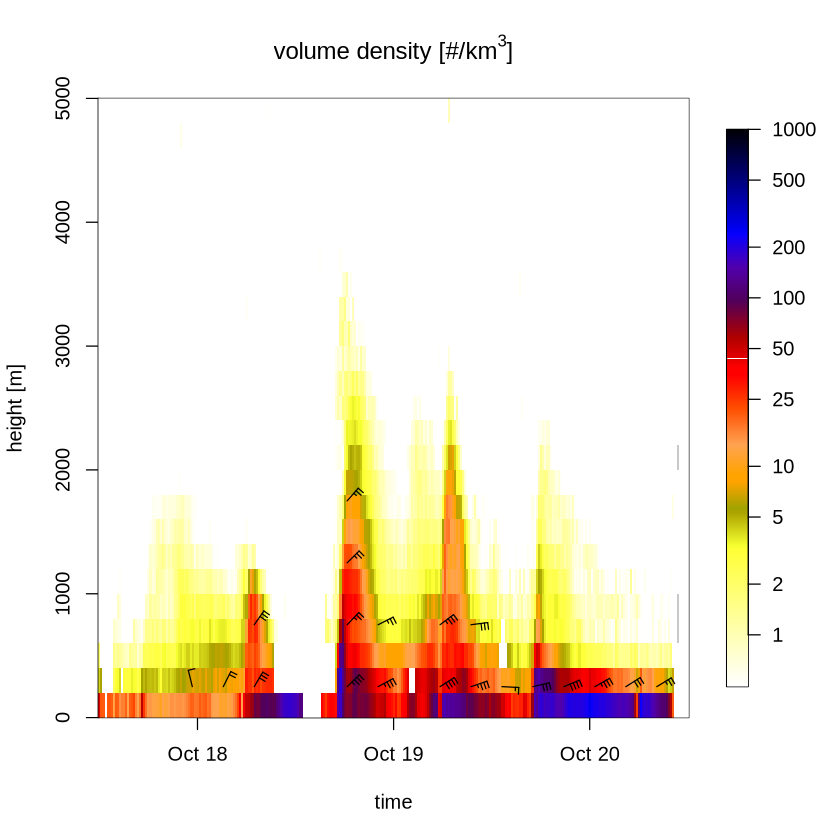

In [11]:
# Load bioRad
library('bioRad')
# Specify the location of where Vertical Profiles are stored
vp_dir <- paste0("/home/jovyan/tutorial_data/naa-vre-user-data/", user_email, "/vp/")
# Return the file paths
vp_file_paths <- list.files(vp_dir, full.name = TRUE, pattern = "*.h5", recursive = TRUE)
# Read the file paths and generate a list of Vertical Profile Objects
vp_list <- bioRad:::read_vpfiles(vp_file_paths)
# convert the list of vertical profiles into a time series:
vpts <- bind_into_vpts(vp_list)
# regularize VPTS
reg_vpts <- regularize_vpts(vpts)
plot(reg_vpts)

This plot shows quite some activity. The graph shows the expected number of birds / km^3. We can see that most of the movement around the radar happened below 1000m. Furthermore, the small 'flags' are windbarbs and show the general speed and direction. 

We can also create a height integrated graph which will display the total number of birds crossing an imaginary line per hour. Excute the cell.

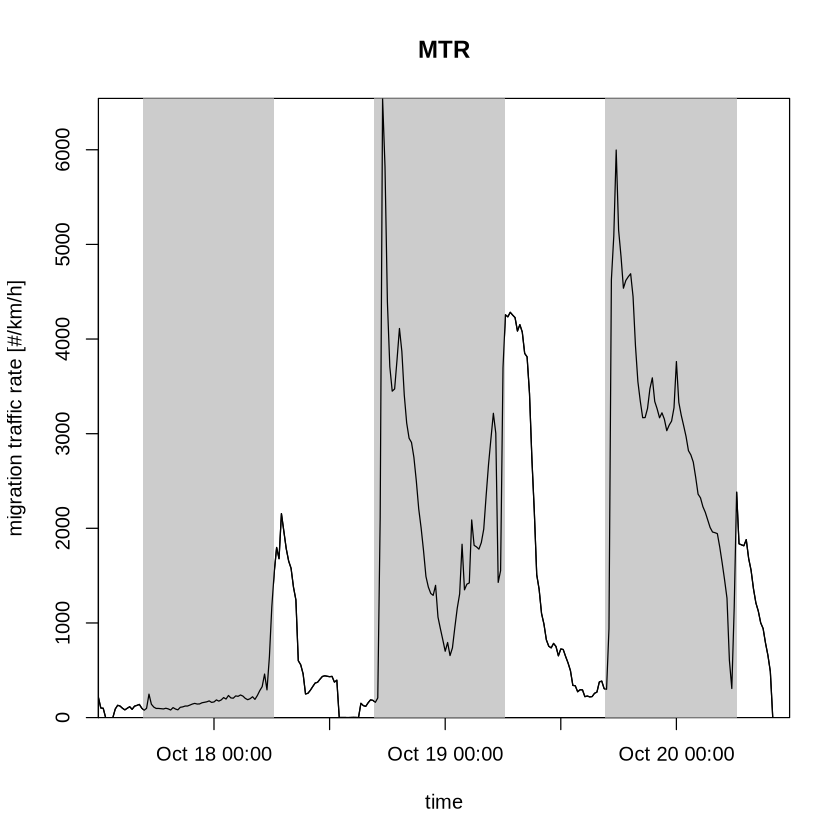

In [12]:
# Plot height integrated graph
integrated_vpts <- integrate_profile(vpts)
plot(integrated_vpts)

This graph is easier to interpret in order to detect when significant animal movement occurs. We can see multiple peaks and dips in the graphs. The shaded areas indicate the time that the sun is down. It looks like there is significant movement in the evenings of 19th and 20th of October. 

### Exercise 3 - Zoom in on Migration with Polar Volumes
Prerequisites: This exercise requires that you have successfully run the cells that store secrets and define methods in exercise 2 (the code cells: _# Set secrets_, _# Methods to download data from MinIO to the virtual lab_ and _# Download vertical profiles_).

First, lets look at a moment with less activity: 2022-10-18 T 16:00 UTC. Run the following cell:

In [13]:
start_date <- "2022-10-18T16:00+00:00"
end_date <- "2022-10-18T16:00+00:00" # Test for a single file
radar <- "herwijnen"
datatype <- "pvol"
bucket_name <- "naa-vre-user-data"
download_data(
  start_date = start_date,
  end_date = end_date,
  radar = radar,
  datatype = datatype,
  user_email = user_email,
  bucket_name = bucket_name
)

[1] "2022-10-18 16:00:00 UTC"
[1] "2022-10-18 16:00:00 UTC"
[1] "Processing first prefix 2022/10/18"
[1] "Downloading NLHRW_pvol_20221018T1600_6356.h5 to /home/jovyan/tutorial_data/naa-vre-user-data/bwijers1@gmail.com/pvol/NL/HRW/2022/10/18//NLHRW_pvol_20221018T1600_6356.h5"


And then in order to visualize, copy the path printed by the download function and paste it in `"<MY_PVOL_PATH>"`:

Zoom: 8



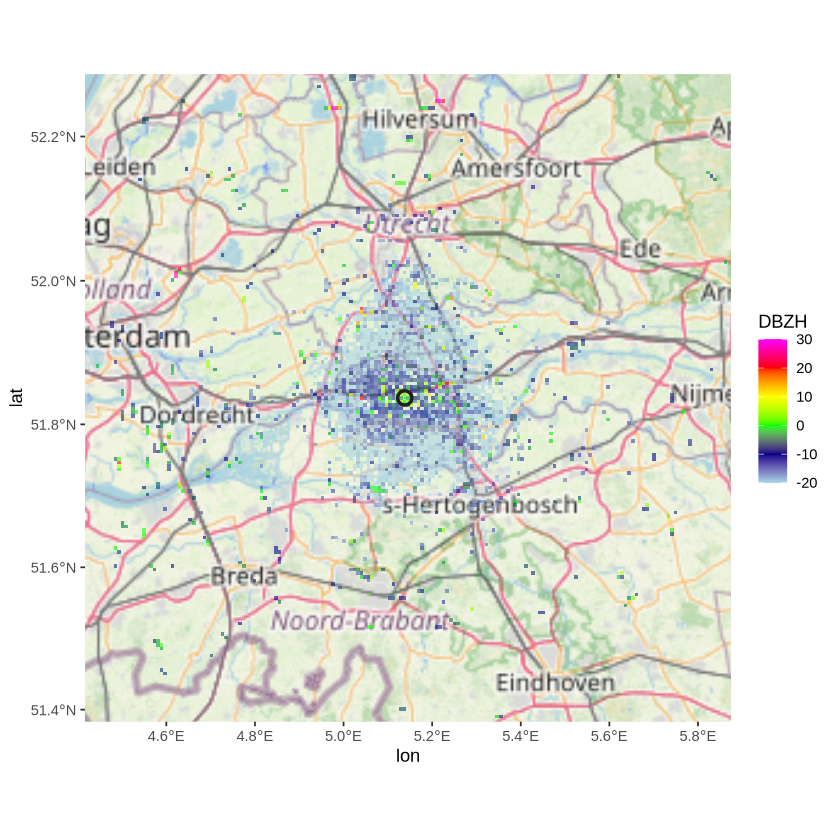

In [17]:
library('bioRad')
target_elevation = 2
target_param = "DBZH"
basemap <- rosm::osm.types()[1]
my_pvol <- bioRad::read_pvolfile("/home/jovyan/tutorial_data/naa-vre-user-data/bwijers1@gmail.com/pvol/NL/HRW/2022/10/18//NLHRW_pvol_20221018T1600_6356.h5",param = c("DBZH","VRADH"))
my_scan <- get_scan(x=my_pvol,
                    elev=target_elevation,
                    all = FALSE)
my_param <- get_param(my_scan,param = target_param)
ppi <- project_as_ppi(my_param)
map(ppi, map = basemap, alpha = 0.6) 

As we can see, there are some reflections being measured quite close around the Radar. 

Lets do the same visualization exercise but for more activity.

According to our integrated graph (Exercise 2 - _# Plot height integrated graph_), we can see that there is a lot of activity going on in the sky around 2022-10-18 T 18:00 UTC. Let's retrieve a Polar Volume for that timestamp and visualize it. 

In [15]:
start_date <- "2022-10-18T18:00+00:00"
end_date <- "2022-10-18T18:00+00:00" # Single file when start and end are identical
radar <- "herwijnen"
datatype <- "pvol"
bucket_name <- "naa-vre-user-data"
download_data(
  start_date = start_date,
  end_date = end_date,
  radar = radar,
  datatype = datatype,
  user_email = user_email,
  bucket_name = bucket_name
)

[1] "2022-10-18 18:00:00 UTC"
[1] "2022-10-18 18:00:00 UTC"
[1] "Processing first prefix 2022/10/18"
[1] "Downloading NLHRW_pvol_20221018T1800_6356.h5 to /home/jovyan/tutorial_data/naa-vre-user-data/bwijers1@gmail.com/pvol/NL/HRW/2022/10/18//NLHRW_pvol_20221018T1800_6356.h5"


We will be visualizing reflectivity (DBZH) for a given elevation angle. A radar scans numerous parameters for a range of elevation angles. We will be retrieving one single elevation angle and look at a single parameter. For the visualization, we will create a Plan Position Indicator (PPI). This centers the radar antenna in the center of the image. We will be placing it on a basemap such that we can see context of the radars location. Lastly, we will be doing this for elevation angle 2.0 (deg). Realize that as the radar beam travels under an angle, it gains altitude. This means that the further the values are the higher they are above ground. 

To visualize it we can use the following code:

Zoom: 8



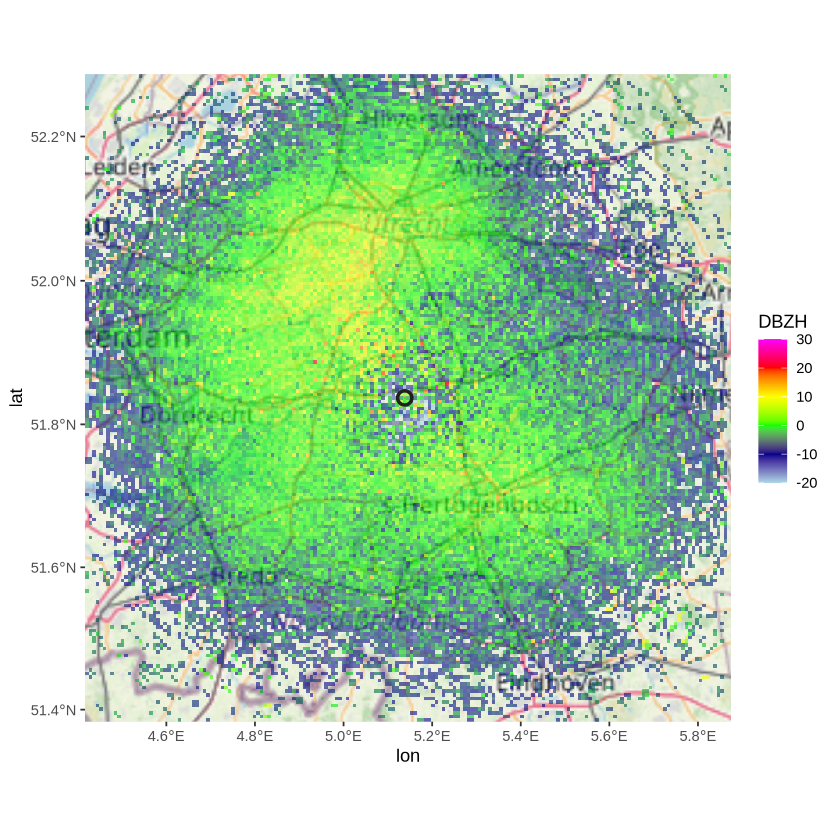

In [18]:
target_elevation = 2
target_param = "DBZH"
basemap <- rosm::osm.types()[1]
my_pvol <- read_pvolfile("/home/jovyan/tutorial_data/naa-vre-user-data/bwijers1@gmail.com/pvol/NL/HRW/2022/10/18//NLHRW_pvol_20221018T1800_6356.h5",param = c("DBZH","VRADH"))
my_scan <- get_scan(x=my_pvol,
                    elev=target_elevation,
                    all = FALSE)
my_param <- get_param(my_scan,param = target_param)
ppi <- project_as_ppi(my_param)
map(ppi, map = basemap, alpha = 0.6) 

Change `"<MY_PVOL_PATH>"` with the path that was printed from retrieving the PVOL and run the cell.


As you can see these two images differ. However, you can't tell without context what is going on: is there any movement at all? Ideally, we would view a animation of the Polar Volume Plan Position Indicators. 

### Exercise 4 - Visualize Plan Position Indicators (PPIs) for a date range
We now have a reasonable idea around which dates and times we can expect a mass migration event. 

However, considering the volume of data and work to be done - we will be using a visualization workflow to produce the Plan Position Indicators (PPI) for a time range of a couple of hours between `2022-10-17` and `2022-10-20`. Rendering a large amount of PPI's with identical settings and location allows us to see some dynamics of the reflectivity measured. 

For this exercise - three workflow nodes need to be made. _S3 PVOL Downloader_, _R PPI_, _S3 PPI Uploader_. We will be connecting them to create a new workflow capable of creating PPI's for a range of data for a given radar.


In `exercise 1` we've used a workflow to process data. Use the experience from `exercise 1` to build a new workflow that creates PPI's. A breakdown of the steps is listed below. We will be using the public dataset of the lab that has been pre-processed. The list shows you parameter boundaries you can chose. Feel free to change `start_date` and `end_date`, `elevation` and `param`. The ["Compose a workflow" paragraph in the NaaVRE tutorial](https://naavre.net/docs/tutorials/#compose-a-workflow) should help you figure out how to do these steps.

[S3-PVOL-Downloader](../codebase/RAVL.ipynb)

1. Navigate to the `Experiment Manager` to create a new workflow.
2. From the cells catalog add the following cells
    * S3-PVOL-Downloader
    * R-PPI
    * S3-PPI-Uploader
3. Attach S3 PVOL Downloader, R PPI and S3 PPI Uploader components together to create a new workflow.
4. Submit the workflow with correct parameters. 
    * Pick a date range. Processing 24 hours of data takes about 8 minutes, so you might want to pick a time interval of a couple of hours with a migration peak in the middle. In order to decide what time interval is interesting to visualise, look at the plots you've made in exercise 1 to pick a time interval that contains a migration peak. 
        * start_date minimum: 2022-10-17T00:00+00:00
        * end_date maximum: 2022-10-20T23:55+00:00
    * radar = `HRW`
    * user_email = `[the e-mail address you used to log into NaaVRE]`
    * elevation
        * Anything between `0` and `90`
    * param
        * `DBZH` or `VRADH`
    * public_minio_data
        * `1`
    * minio_access_key
        * See "MinIO storage" paragraph.
    * minio_secret_key
        * See "MinIO storage" paragraph.

One of the components you are using in this workflow (`R-PPI`) is created using the source code shown below. It is adjusted R code similiar to that we've used in the notebook during exercise 3. This code has been adjusted for containerization and re-use in a workflow. In this case, certain variables have been prefixed with `param_`, `conf_`, `secret_`. Furthermore, the code body now revolves around a `for loop` such that it can create the visualization for one or more `PVOLs`.  

Once the workflow has succesfully concluded, it is time to retrieve the data and create an animation. The workflow has automagically uploaded your data to the [MinIO](https://scruffy.lab.uvalight.net:9001). You should be able to find your data by navigating to: `naa-vre-user-data` -> [the e-mail address you used to log into NaaVRE] -> `ppi` -> `NL` -> `HRW` -> `2022` -> `10`. You will see multiple directories, based upon your `start_date` and `end_date` settings. The workflow will have created a `ppi` for each `pvol` file that was available within your `start_date` and `end_date` range. You can select all directories by hitting the empty box on the top

![images/download_ppi_minio.png](images/download_ppi_minio.png) 

and then on the right side - hit `download` 

![images/download_ppi_minio_2.png](images/download_ppi_minio_2.png)

Save the zip file somewhere on your computer. Once the zipfile has been downloaded, proceed to unpack the zipfile.

Animating the images can be done with [ezgif](https://ezgif.com/maker). Drag the images you've downloaded into [ezgif](https://ezgif.com/maker). Keep all settings default, hit `Upload files`. Again, keep all settings default and hit `Make a GIF!`. After a short while, you should be able to see an animation of PPI's. Have a look and see if you can see the change in reflections and movement of biological echoes.

## Exercises summary
You've now:
1. Submitted multiple workflows causing Virtual Machines to start, communicate and stop automatically.
2. Downloaded Weather Radar Data from the Royal Dutch Meteorological Institute (KNMI).
3. Converted it to a industry standard format `ODIM`.
4. Produced derivative data (Vertical Profiles) by using the vol2bird algorithm.
5. Retrieved Polar Volume and Vertical Profile data from the cloud.
6. Visualized Vertical Profiles in time-series.
7. Created and visualized Plan Position Indicators made from reflectivity from Polar Volume scans.
8. Built a new workflow for visualizing polar volume data for a time range.
9. Parametrised a new workflow to produce Plan Position Indicators for a potential migration event through cloud computing.
10. Created an animation from Plan Position Indicators, visualizing Radar images measuring actual biological movement.

You've now completed the exercises for the tutorial for RAVL. However, there are a host of other things to do. Below, we've added some extra information and exercises to get you started on more open ended questions. There are two exercises set up where you will explore radar data to gain insight on peak migration and the effects of fireworks on local bird population. The peak migration exploration is done by using external databases to give an indication on when potential mass migration events could occur and then inspect those moments by visualizing VPTS and PPI. The fireworks exercise will guide you in exploring the effects of fireworks on birds in The Netherlands. The Netherlands has a liberal fireworks policy except during the pandemic which is an unique time-period to investigate. 

# Open questions
## Identifying migration moments 
As the above list shows - you've accomplished a great deal. For this course text, we've provided some information on when we can expect certain migratory events. As an open exercise, feel free to use all the knowledge and information you've gained to find a _new_ migration event. This time - we do not have the convenience of having a line graph indicating moments of high migration. You also do not have the time during this tutorial to process a full year of data for a given radar. So, instead, try and use external sources. 

We now know that passerines:
1. Wait for favourable wind conditions
2. In Autumn, migrate predominately in a North -> South, SouthWest fashion
3. In Spring migrate predominately in a South -> North, NorthEast fashion
4. Will migrate after sunset and before sunrise

You will use an external database for Wind to find favourable wind conditions in either migratory season for a year of your choice. Try and find a date that would have proper wind conditions. You can also check weather forecasts and reports to see if that particular day had a lot of rain or not. If it did - birds likely stayed aground. 

Once you've found a date, set all parameters for a day before and after. Then go through all exercises but now with your own start and end date. 

### Peak migration events based on Weather variables
As mentioned in the introduction, it seems that birds tend to wait for favourable weather conditions before departing. Sometimes it takes too long to find these weather conditions and the birds depart in seemingly bad conditions. Therefore, we can't fully say when they depart but we can have a good estimate of when could be a good moment. By reviewing weather variables we can therefore estimate when birds could be departing en masse. 

Objective: Use weather variables to estimate when there would be a peak migration event. Once identified, generate PVOL and VP and visualize the results. 

### Information
The website you can use to view a host of weather variables can be found here: [earth.nullschool.net](https://earth.nullschool.net/#2017/07/26/2200Z/wind/surface/level/orthographic=7.88,51.69,2762/loc=7.511,49.824). For Autumn migration, winds originating from the North and heading South, SouthWest seem to be favourable for passerine migration. In Spring (February - May) winds originating from the South and heading North NorthEast seem to be favourable. Furthermore, regardless of season rain is not favourable. 

To get you started, a few dates will be shown to you of where there is a peak migration event positive weather variables. Try some of the dates and see if you can see the favourable wind conditions. Also see what the wind direction was before the 8th of october and after the 13th of october, 2022. After that, use the earth.nullschool.net website to find more moments in time that could warrant peak migration. Pick one and visualize and verify.

Night of 8th of October, 2022
```python
start_date = '2022-10-08T18:00:00+00:00'
end_date = '2022-10-09T06:00:00+00:00'
radar = 'herwijnen' # denhelder not available
```
Night of 9th of October, 2022
```python
start_date = '2022-10-09T18:00:00+00:00'
end_date = '2022-10-10T06:00:00+00:00'
radar = 'herwijnen' # denhelder not available
```
Night of 10th of October, 2022
```python
start_date = '2022-10-10T18:00:00+00:00'
end_date = '2022-10-11T06:00:00+00:00'
radar = 'herwijnen' # or denhelder
```
Night of 11th of October, 2022
```python
start_date = '2022-10-11T18:00:00+00:00'
end_date = '2022-10-12T06:00:00+00:00'
radar = 'herwijnen' # or denhelder
```
Night of 12th of October, 2022
```python
start_date = '2022-10-12T18:00:00+00:00'
end_date = '2022-10-13T06:00:00+00:00'
radar = 'herwijnen' # or denhelder
```
This night specifically is rather spectacular and has very telling weather variables before and during.
Night of 18th of Ocotber, 2022
```python
start_date = '2021-10-18T18:00:00+00:00'
end_date = '2022-10-19T06:00:00+00:00'
radar = 'herwijnen' # or denhelder
```
The following dates are peak migration nights but the weather variables are not favourable. Have a look at these dates and also look at the weather variables before and after the migration. We expect the birds to have left as they waited long enough and decided to migrate in less optimal conditions. 
Night of 6th of Ocotber, 2021
```python
start_date = '2021-10-06T18:00:00+00:00'
end_date = '2022-10-07T06:00:00+00:00'
radar = 'herwijnen' # or denhelder
```
Night of 7th of Ocotber, 2021
```python
start_date = '2021-10-07T18:00:00+00:00'
end_date = '2022-10-08T06:00:00+00:00'
radar = 'herwijnen' # or denhelder
```
Night of 8th of Ocotber, 2021
```python
start_date = '2021-10-08T18:00:00+00:00'
end_date = '2022-10-09T06:00:00+00:00'
radar = 'herwijnen' # or denhelder
```
Night of 12th of Ocotber, 2021
```python
start_date = '2021-10-06T18:00:00+00:00'
end_date = '2022-10-07T06:00:00+00:00'
radar = 'herwijnen' # or denhelder
```
Night of 13th of Ocotber, 2021
```python
start_date = '2021-10-06T18:00:00+00:00'
end_date = '2022-10-07T06:00:00+00:00'
radar = 'herwijnen' # or denhelder
```


### Extra information
You can e-mail your findings to `b.c.wijers@uva.nl` with the title `Lifewatch BEes 25 RAVL - Peak migration`. We will then discuss your findings with the Animal Movement Ecology group and provide feedback. 


## Fireworks and Birds. 
Quite some research is being done to determine the effect and scope of fireworks on birds. I think we can all imagine the effect fireworks has on birds - but can we see this effect in Radar Data?

Objective: Generate Polar Volumes and Vertical Profiles for either (or both) radars around New Years Eve. 

First, visualize and interpret one New Years Eve. Once done - create a larger temporal span (i.e. include more years) and interpret the effect of fireworks on birds over the year. 
* Is the effect of Fireworks increasing, decreasing, other?
* What happened during the Corona Pandemic. Did we see an increase, decrease, other effect? 
  1. During the Corona Pandemic, The Netherlands banned the use of all fireworks by it's citizens. 
  2. During 'normal' years The Netherlands allows its citizens to be launch a great variation of fireworks. 


### Extra information
You can e-mail your findings to `b.c.wijers@uva.nl` with the title `Lifewatch BEes 25 RAVL - Fireworks`. We will then discuss your findings with the Animal Movement Ecology group and provide feedback. 


# Publications and papers regarding migration
* Kranstauber B, Bouten W, van Gasteren H, Shamoun-Baranes J. 2022. Ensemble
predictions are essential for accurate bird migration forecasts for conservation
and flight safety. Ecological Solutions and Evidence 3(3)
* van Dobben H, 1953. Bird migration in the Netherlands. Ibis (95)
* van Doren BM, Horton KG. 2018. A continental system for forecasting bird migration.
Science 361:1115–1118.
* Richardson WJ. 1978. Timing and Amount of Bird Migration in Relation to Weather:
A Review. Oikos 30:224–272.

# Open data repositories
* Vertical profiles in Europe
    * [aloftdata](https://aloftdata.eu/)
* Polar Volume data The Netherlands
    * [knmi](https://data.knmi.nl)
* Polar Volume data Germany
    * [dwd](https://opendata.dwd.de/)
* Polar Volume Data Danmark
    * [dmi](https://confluence.govcloud.dk/display/FDAPI)

# Reusability of data produced in radaero exercises
The data you've produced can be analyzed with the bioRad package. [RadAero2022](https://adriaandokter.com/bioRad/articles/rad_aero_22.html) are introductory exercises on bioRad where you will be reading Polar Volumes, Vertical Profiles generating and Range Bias Corrected data. All data generated in this course can be used in the RadAero2022 exercises in bioRad. You can skip downloading vertical profiles and polar volumes in the RadAero2022 exercises as you have just generated those in your RAVL environment. It is recommended to have a look and try some of these commands on the data you've just produced. 

# Feedback
Please consider filling in the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLScpARhb0qUTZFZKvnOgpnD2mFr_jxix7yMcyshltmjv5ALmIg/viewform?usp=dialog). We highly appreciate any feedback on the virtual lab and the tutorial.